# Noise Model Diagnostics: Residuals Standard Deviation and Magnitude

This example introduces two noise model diagnostics which are useful for studying the variance in time series noise.

The general procedure we follow in this notebook is to start by performing a fit assuming an IID noise process. Next, we generate the diagnostic plots from the IID residuals, and see if they suggest that a more complex noise process is appropriate.

The two diagnostics demonstrated in this notebook are `pints.residuals_diagnostics.plot_residuals_binned_std` and `pints.residuals_diagnostics.plot_residuals_vs_output`. Both methods can take either a single best fit parameter or an MCMC chain of posterior samples. 

The diagnostic plots in the notebook can be used to study the variance of the residuals. Pints also contains diagnostics for studying correlated noise processes, which are covered in [Evaluating noise models using autocorrelation plots of the residuals](residuals-autocorrelation.ipynb) and [Noise model autocorrelation diagnostic plots](residuals-autocorrelation-diagnostics.ipynb).

## Time series with non-IID noise

First, we generate a time series from the logistic model, and add a noise process whose magnitude varies over time. Specifically we use multiplicative noise, in which the magnitude of the noise terms are proportional to the value of the time series. This noise process is discussed in further detail in [Multiplicative Gaussian noise](../stats/multiplicative-gaussian-errors.ipynb).

We then fit the logistic parameters assuming standard IID noise, which will yield a best fit and corresponding residuals.

In [1]:
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Use the toy logistic model
model = toy.LogisticModel(initial_population_size=1000)

real_parameters = [0.0001, 10]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add independent Gaussian noise
noise = 50
values = org_values + pints.noise.multiplicative_gaussian(0.8, 0.5, org_values)

# Set up the problem and run the optimisation 
problem = pints.SingleOutputProblem(model, times, values)

score = pints.SumOfSquaresError(problem)
boundaries = pints.RectangularBoundaries([0, 0], [1, 1000])
x0 = np.array([0.001, 500])

found_parameters, found_value = pints.optimise(
    score,
    x0,
    boundaries=boundaries,
    method=pints.XNES,
    )

print('Score at true solution: ')
print(score(real_parameters))

print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Time m:s
0     6      3.55e+07   0:00.0
1     12     2.73e+07   0:00.0
2     18     2.73e+07   0:00.0
3     24     1.26e+07   0:00.0
20    126    3328023    0:00.0
40    246    2464724    0:00.0
60    366    2411056    0:00.0
80    486    2371998    0:00.0
100   606    2331100    0:00.1
120   726    2283589    0:00.1
140   846    2269777    0:00.1
160   966    2247826    0:00.1
180   1086   2222876    0:00.1
200   1206   2210433    0:00.1
220   1326   2199799    0:00.1
240   1446   2191463    0:00.1
260   1566   2185720    0:00.1
280   1686   2181675    0:00.2
300   1806   2176351    0:00.2
320   1926   2172614    0:00.2
340   2046   2170907    0:00.2
360   2166   2169737    0:00.2
380   2286   2163918    0:00.2
400   2406   2162641    0:00.2
420   2526   2160090    0:00.2
440   2646   2154964    0:00.2
460   2766   2152116    0:00.3
480   28

5480  32886  2094576    0:03.1
5500  33006  2094572    0:03.1
5520  33126  2094561    0:03.1
5540  33246  2094550    0:03.1
5560  33366  2094540    0:03.1
5580  33486  2094526    0:03.2
5600  33606  2094510    0:03.2
5620  33726  2094499    0:03.2
5640  33846  2094490    0:03.2
5660  33966  2094485    0:03.2
5680  34086  2094481    0:03.2
5700  34206  2094455    0:03.2
5720  34326  2094430    0:03.2
5740  34446  2094419    0:03.2
5760  34566  2094406    0:03.3
5780  34686  2094396    0:03.3
5800  34806  2094392    0:03.3
5820  34926  2094388    0:03.3
5840  35046  2094380    0:03.3
5860  35166  2094370    0:03.3
5880  35286  2094362    0:03.3
5900  35406  2094352    0:03.3
5920  35526  2094340    0:03.3
5940  35646  2094333    0:03.4
5960  35766  2094309    0:03.4
5980  35886  2094300    0:03.4
6000  36006  2094293    0:03.4
6020  36126  2094280    0:03.4
6040  36246  2094245    0:03.4
6060  36366  2094226    0:03.4
6080  36486  2094216    0:03.4
6100  36606  2094204    0:03.4
6120  36

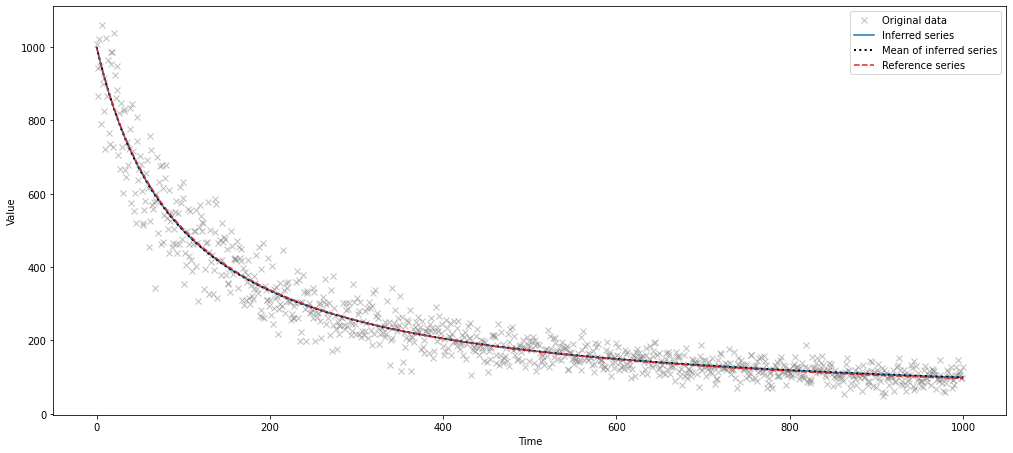

In [2]:
fig, ax = pints.plot.series(np.array([found_parameters]), problem, ref_parameters=real_parameters)
fig.set_size_inches(15, 7.5)
plt.show()

## Binned residuals standard deviation

Having obtained the IID fit, we now generate some diagnostic plots to see whether the IID assumption is valid (since the data was generated using multiplicative noise, we expect to find evidence that IID is not appropriate).

The first diagnostic plot divides the time series into bins, and displays the standard deviation of the residuals calculated within each bin over time. This function is available from Pints using `pints.residuals_diagnostics.plot_residuals_binned_std`. 

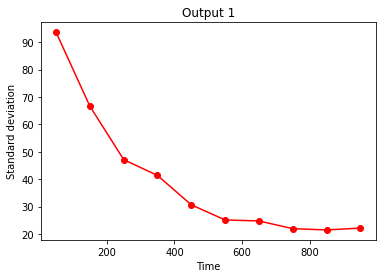

In [3]:
from pints.residuals_diagnostics import plot_residuals_binned_std

fig = plot_residuals_binned_std(
    np.array([found_parameters]),
    problem,
    n_bins=10
)

plt.show()

This plot shows the a steady decrease in the residuals variance over time, suggesting (correctly) that the noise is not actually IID.

## Residuals vs output

Another diagnostic plot which helps to analyse the residuals is available in Pints using the `plot_residuals_vs_output` function in `pints.residuals_diagnostics`. This plot compares the magnitude of the residuals to the values of the solution.

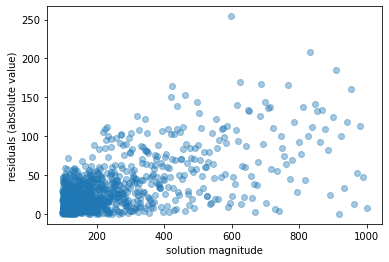

In [4]:
from pints.residuals_diagnostics import plot_residuals_vs_output

fig = plot_residuals_vs_output(
    np.array([found_parameters]),
    problem
)

plt.show()

This plot shows that as the solution magnitude increases, so does the magnitude of the residuals.

Taken together, the two diagnostic plots in this notebook provide good evidence that the noise is not IID, and a multiplicative noise process would be a better choice for another round of optimisation or MCMC inference.